In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from fitter import Fitter
import os
import copy
from scipy.stats import skew, kurtosis, spearmanr
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from skimage.feature import greycomatrix, greycoprops
from skimage import data
import time

In [2]:
# as input np.array[NxM], dtype=int8
# returns as input np.array[N-1xM-1], dtype=int64

def getNormArr(a):
    a = a.astype(int)
    normArr = []
    for i in range(a.shape[0]):
#     for i in range(a.shape[1]):
        newList = []
        for j in range(a.shape[1] - 1):
#         for j in range(a.shape[0] - 1):
            newList.append(a[i][j + 1] - a[i][j])
#             newList.append(a[j + 1][i] - a[j][i])
        normArr.append(newList)
    minArr = np.amin(normArr)
    if (minArr < 0):
        minArr = abs(minArr)
        for i in range(len(normArr)):
            for j in range(len(normArr[0])):
                normArr[i][j] += minArr
    return np.asarray(normArr, dtype='int8')

In [3]:
#     Function reads all images from folder at path 'roi_path'
# count normalized GLCM for every image and appends it to general 
# list of GLCMs wich will be returned

def load_ROI_GLCM(roi_path):
    load_folder = roi_path
    image_files = os.listdir(load_folder)
    glcms_list = []
    for img_name in image_files:  
        img = cv2.imread(os.path.join(load_folder, img_name), cv2.IMREAD_GRAYSCALE) # Reading image in grayscale
        img = getNormArr(img)    #Normalizing image
        # Calculating Gray Level Co-Occurrence Matrix
        glcm = greycomatrix(img,                   # Source image
                            distances=[1],         # List of pixel pair distance offsets.
                            angles=[0],            # List of pixel pair angles in radians.
                            levels=128,
                            symmetric=True,        # If True, the output matrix is symmetric
                            normed=True)           # If True, normalize each matrix value by dividing 
                                                   # by the total number of accumulated co-occurrences for the given offset.
        glcms_list.append(glcm)
    return glcms_list

In [4]:
# Feature extraction function
# Returns array of features
def feature_extract(glcm):
    fs = []
    fs.append(greycoprops(glcm, 'contrast')[0, 0])
    fs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    fs.append(greycoprops(glcm, 'homogeneity')[0, 0])
    fs.append(greycoprops(glcm, 'energy')[0, 0])
    fs.append(greycoprops(glcm, 'correlation')[0, 0])
    fs.append(greycoprops(glcm, 'ASM')[0, 0])
    return np.array(fs)

In [5]:
def create_differnce_glcm(glcms_norm, glcms_pat):
    glcm_norm_sum = sum(glcms_norm) / len(glcms_norm)   # TODO: ask about dividing on amount of objects
    glcm_pat_sum = sum(glcms_pat) / len(glcms_pat)      # TODO: ask about dividing on amount of objects
    glcm_diff = glcm_norm_sum - glcm_pat_sum
    return glcm_diff

In [6]:


# norm_roi_path = "/home/mhoncharuk/Education/liver_disease_recognizer/dataset/ROI/Norma/CL/"
# pat_roi_path = "/home/mhoncharuk/Education/liver_disease_recognizer/dataset/ROI/Pathology/CL/"
# test_norm = load_ROI_GLCM(norm_roi_path)
# test_norm_sum = sum(test_norm)
# divider = test_norm_sum.sum()
# test_norm_sum = test_norm_sum / (divider*162)
# res = test_norm - glcm_norm_sum


In [5]:
norm_roi_path = "/home/mhoncharuk/Education/liver_disease_recognizer/dataset/ROI/Norma/CL/"
pat_roi_path = "/home/mhoncharuk/Education/liver_disease_recognizer/dataset/ROI/Pathology/CL/"

In [6]:
glcms_norm = load_ROI_GLCM(norm_roi_path)
glcms_pat = load_ROI_GLCM(pat_roi_path)



In [35]:
glcm_diff = create_differnce_glcm(glcms_norm, glcms_pat)
res = np.reshape(glcm_diff, (128, 128))
df = pd.DataFrame(res[:80, :80])
df.to_excel('/home/mhoncharuk/Education/liver_disease_recognizer/notebooks/GLCM_Diff.xlsx')


In [9]:
# Form dataset with features.

general_list = glcms_norm + glcms_pat
X_glcm = np.array([feature_extract(i) for i in general_list])
y_glcm = np.array([0 if i < len(glcms_norm) else 1 for i in range(len(general_list))])


In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_glcm, y_glcm, test_size=.15, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)

clf = RandomForestClassifier(max_depth=5000, 
                            random_state=666,
                            class_weight="balanced")
clf.fit(X_train, y_train)

confidence = clf.score(X_test, y_test)
print('accuracy:', confidence)

In [ ]:
def calc_correlation(df):
    new_data = []
    for i in range(df.shape[1]):
        new_row = []
        for j in range(df.shape[1]):
            rho, pval = spearmanr(df[i],df[j])
            new_row.append(rho)
        new_data.append(new_row)
    return pd.DataFrame(new_data)


def calc_corr(df):
    new_data = []
    for i in cut_dataset.columns:
        new_row = []
        for j in cut_dataset.columns:
            rho, pval = spearmanr(df[i],df[j])
            new_row.append(rho)
        new_data.append(new_row)
    return pd.DataFrame(new_data)
# correlations = calc_correlation(df)
# correlations.to_excel('/home/mhoncharuk/Education/liver_disease_recognizer/notebooks/GLCM_Diff_corr.xlsx', index=False)

In [91]:
def feature_extract_plus(glcm, top_pairs):
    features = [glcm[i[0]][i[1]][0, 0] for i in top_pairs]
    fs.append(greycoprops(glcm, 'contrast')[0, 0])
    fs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    fs.append(greycoprops(glcm, 'homogeneity')[0, 0])
    fs.append(greycoprops(glcm, 'energy')[0, 0])
    fs.append(greycoprops(glcm, 'correlation')[0, 0])
    fs.append(greycoprops(glcm, 'ASM')[0, 0])
    
    return np.array(features + fs)

# general_list = glcms_norm + glcms_pat
# X_glcm = np.array([feature_extract(i) for i in general_list])
# y_glcm = np.array([0 if i < len(glcms_norm) else 1 for i in range(len(general_list))])

In [76]:
general_list = glcms_norm + glcms_pat
clapped_data = np.array([i.flatten() for i in general_list])
res_df = pd.DataFrame(clapped_data)
res_df.insert(res_df.shape[1], "class", y_glcm, True)

drop_cols = []
cut_dataset = res_df
cut_percent = min(len(glcms_norm), len(glcms_pat)) / (len(glcms_norm) + len(glcms_pat))
# cut_percent = 0.4
for i in range(clapped_data.shape[1]):
    if ((sum(cut_dataset[i]==0) / clapped_data.shape[0]) > cut_percent):
        drop_cols.append(i)
cut_dataset = cut_dataset.drop(drop_cols, axis=1)
# cut_dataset.to_excel("rowed_matrixes.xlsx")


correlations = calc_corr(cut_dataset)
correlations.to_excel('/home/mhoncharuk/Education/liver_disease_recognizer/notebooks/GLCM_Diff_corr.xlsx', index=False)


# calculating best pairs
#------


In [55]:
clapped_data = np.array([i.flatten() for i in general_list])
res_df = pd.DataFrame(clapped_data)
res_df.insert(res_df.shape[1], "class", y_glcm, True)

# drop_cols = []
# cut_dataset = res_df
# # cut_percent = min(len(glcms_norm), len(glcms_pat)) / (len(glcms_norm) + len(glcms_pat))
# cut_percent = 0.6
# for i in range(clapped_data.shape[1]):
#     if ((sum(cut_dataset[i]==0) / clapped_data.shape[0]) > cut_percent):
#         drop_cols.append(i)
# cut_dataset = cut_dataset.drop(drop_cols, axis=1)
# cut_dataset.to_excel("rowed_matrixes.xlsx")


# correlations = calc_corr(cut_dataset)
# correlations.to_excel('/home/mhoncharuk/Education/liver_disease_recognizer/notebooks/GLCM_Diff_corr.xlsx', index=False)


In [71]:
drop_cols = []
cut_dataset = res_df
# cut_percent = min(len(glcms_norm), len(glcms_pat)) / (len(glcms_norm) + len(glcms_pat))
cut_percent = 0.4
for i in range(clapped_data.shape[1]):
    if ((sum(cut_dataset[i]==0) / clapped_data.shape[0]) > cut_percent):
        drop_cols.append(i)
cut_dataset = cut_dataset.drop(drop_cols, axis=1)

In [72]:
cut_dataset.shape

(260, 554)

In [73]:
min(len(glcms_norm), len(glcms_pat)) / (len(glcms_norm) + len(glcms_pat))

0.3769230769230769

In [92]:
from_gen_alg = [69, 282, 309, 406, 545, 663]
clapped_data = np.array([i.flatten() for i in general_list])
res_df = pd.DataFrame(clapped_data)

top_columns = [res_df.columns[i] for i in from_gen_alg]
top_pairs = [(i//128, i%128) for i in top_columns]

In [83]:
top_pairs


[(0, 69), (2, 26), (2, 53), (3, 22), (4, 33), (5, 23)]

In [84]:
def feature_extract_plus(glcm, top_pairs):
    fs = []
#     fs.append(greycoprops(glcm, 'contrast')[0, 0])
#     fs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
#     fs.append(greycoprops(glcm, 'homogeneity')[0, 0])
#     fs.append(greycoprops(glcm, 'energy')[0, 0])
#     fs.append(greycoprops(glcm, 'correlation')[0, 0])
#     fs.append(greycoprops(glcm, 'ASM')[0, 0])
    fs2 = [glcm[i[0]][i[1]][0, 0] for i in top_pairs]
    
    return np.array(fs + fs2)




general_list = glcms_norm + glcms_pat
X_glcm = np.array([feature_extract_plus(i, top_pairs) for i in general_list])
# X_glcm = np.array([feature_extract(i) for i in general_list])
y_glcm = np.array([0 if i < len(glcms_norm) else 1 for i in range(len(general_list))])



In [85]:
X_glcm

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.2985882e-05,
        0.0000000e+00, 3.2985882e-05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [253]:
X_train, X_test, y_train, y_test = \
    train_test_split(np.array(cut_dataset.drop('class', axis=1)), y_glcm, test_size=.15, random_state=42)

In [86]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_glcm, y_glcm, test_size=.15, random_state=42)

In [82]:
X_train


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [13]:
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=None, max_features='auto', max_leaf_nodes=None,
#             min_impurity_split=1e-07, min_samples_leaf=1,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
#             verbose=0, warm_start=False)

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)

clf = RandomForestClassifier(max_depth=5000, 
                            random_state=666,
                            class_weight="balanced")
clf.fit(X_train, y_train)

confidence = clf.score(X_test, y_test)
print('accuracy:', confidence)

accuracy: 0.4358974358974359


In [46]:

print("Train size: \t", X_train.shape, "\nTest size: \t", X_test.shape)
print('accuracy:', confidence)

Train size: 	 (221, 6) 
Test size: 	 (39, 6)
accuracy: 0.7948717948717948


In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

confidence = clf.score(X_test, y_test)
print('accuracy:', confidence)

accuracy: 0.48717948717948717


In [50]:
len(glcms_pat)

98

ValueError: query data dimension must match training data dimension

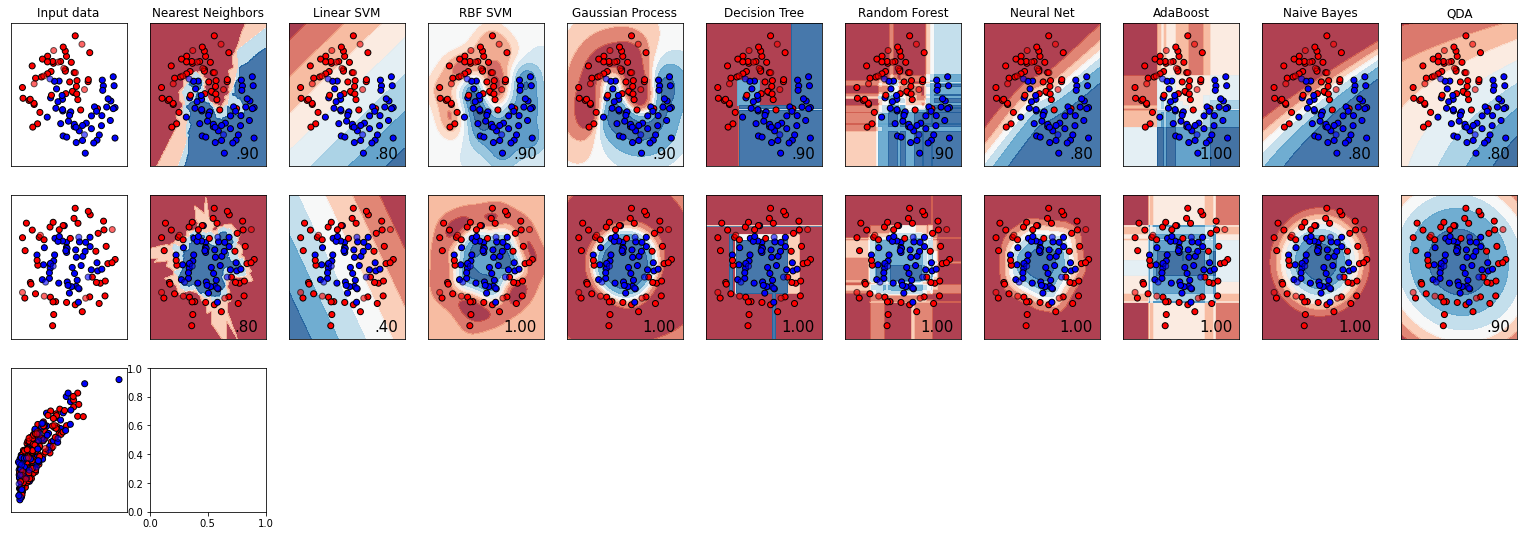

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# X, y = make_classification(n_samples = 260, n_features=2, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)

X = X_glcm
y = y_glcm

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.1, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

#         if hasattr(clf, "decision_function"):
#             Z = clf.decision_function(np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(4)]).T)
#         else:
#             Z = clf.predict_proba(np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(4)]).T)[:, 1]
            
            
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [32]:
X = StandardScaler().fit_transform(X_glcm)

In [34]:
 X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.1, random_state=42)

In [36]:
X_test.shape

(26, 6)

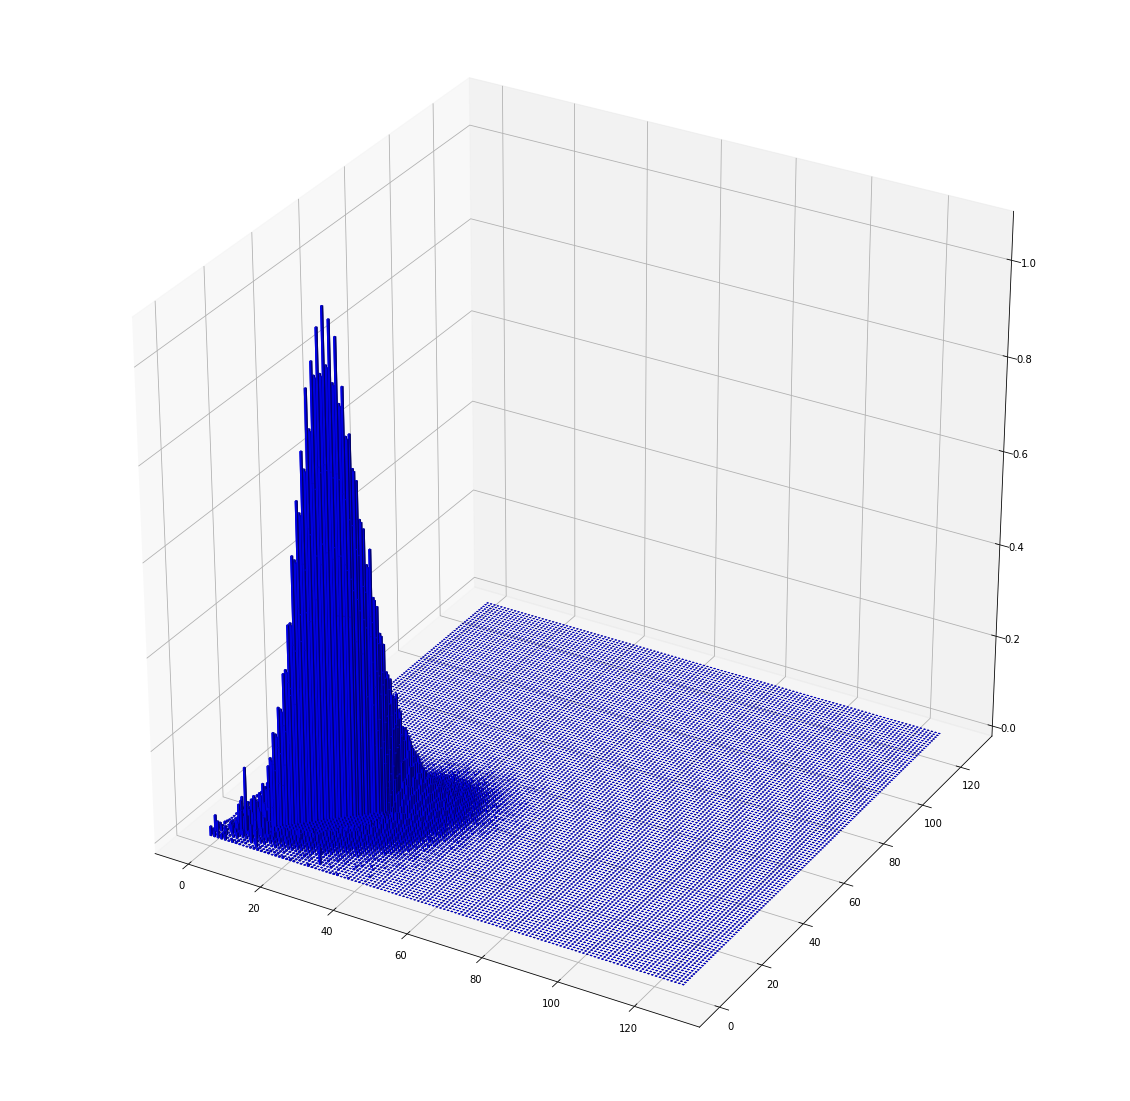

In [39]:
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=20,20
matrix = sum(glcms_norm)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xpos = [range(matrix.shape[0])]
ypos = [range(matrix.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = matrix.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
# fig=plt.figure(figsize=(20, 20), dpi= 80)
plt.savefig('Diff_Glcms_Norm-Pat.png')
plt.show()


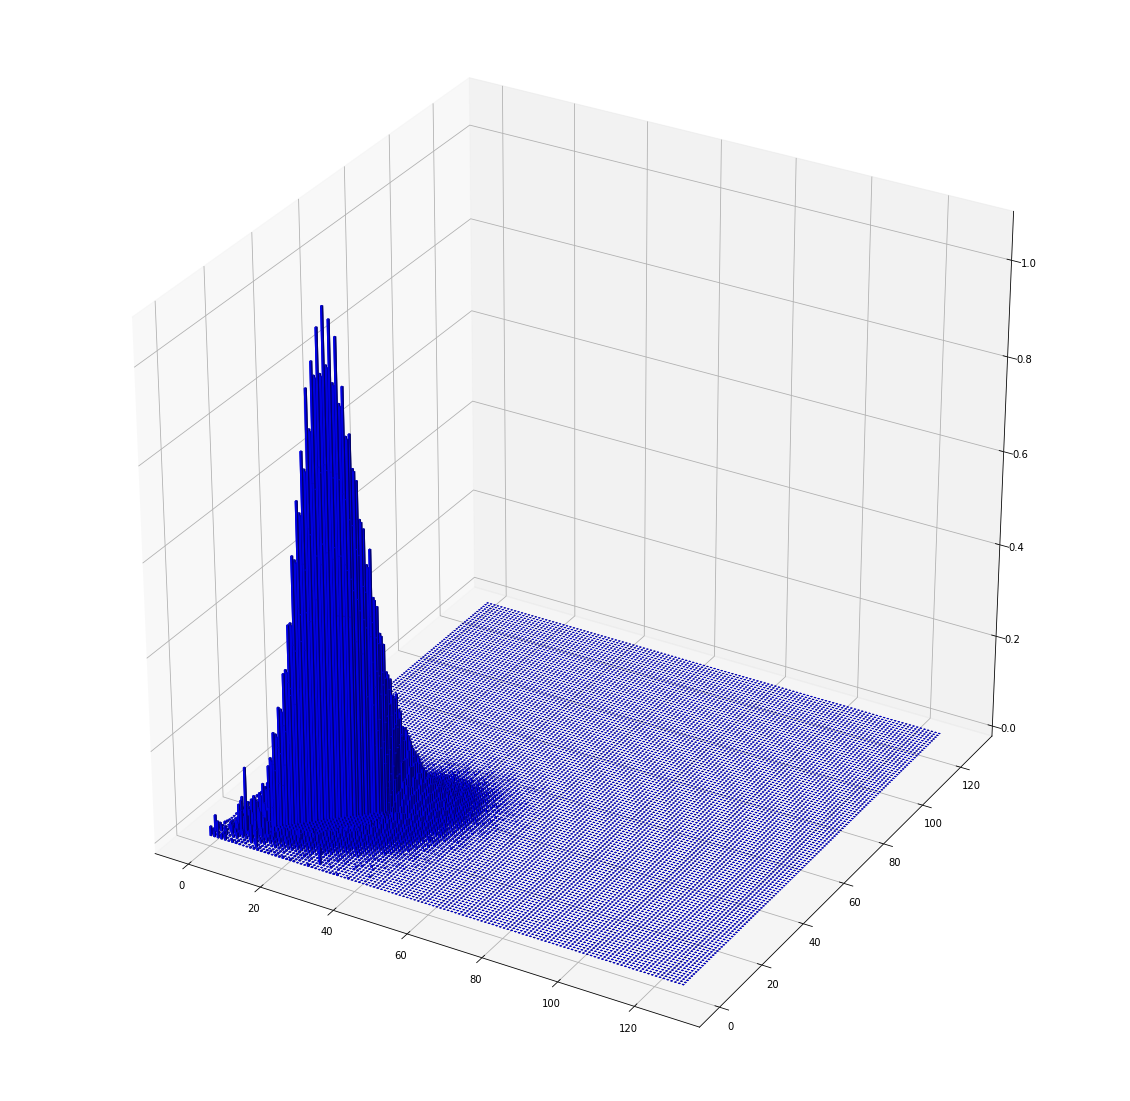

In [38]:
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=20,20
matrix = glcm_norm_sum

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xpos = [range(matrix.shape[0])]
ypos = [range(matrix.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = matrix.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
# fig=plt.figure(figsize=(20, 20), dpi= 80)
plt.savefig('Glcms_Mid_Norm.png')
plt.show()

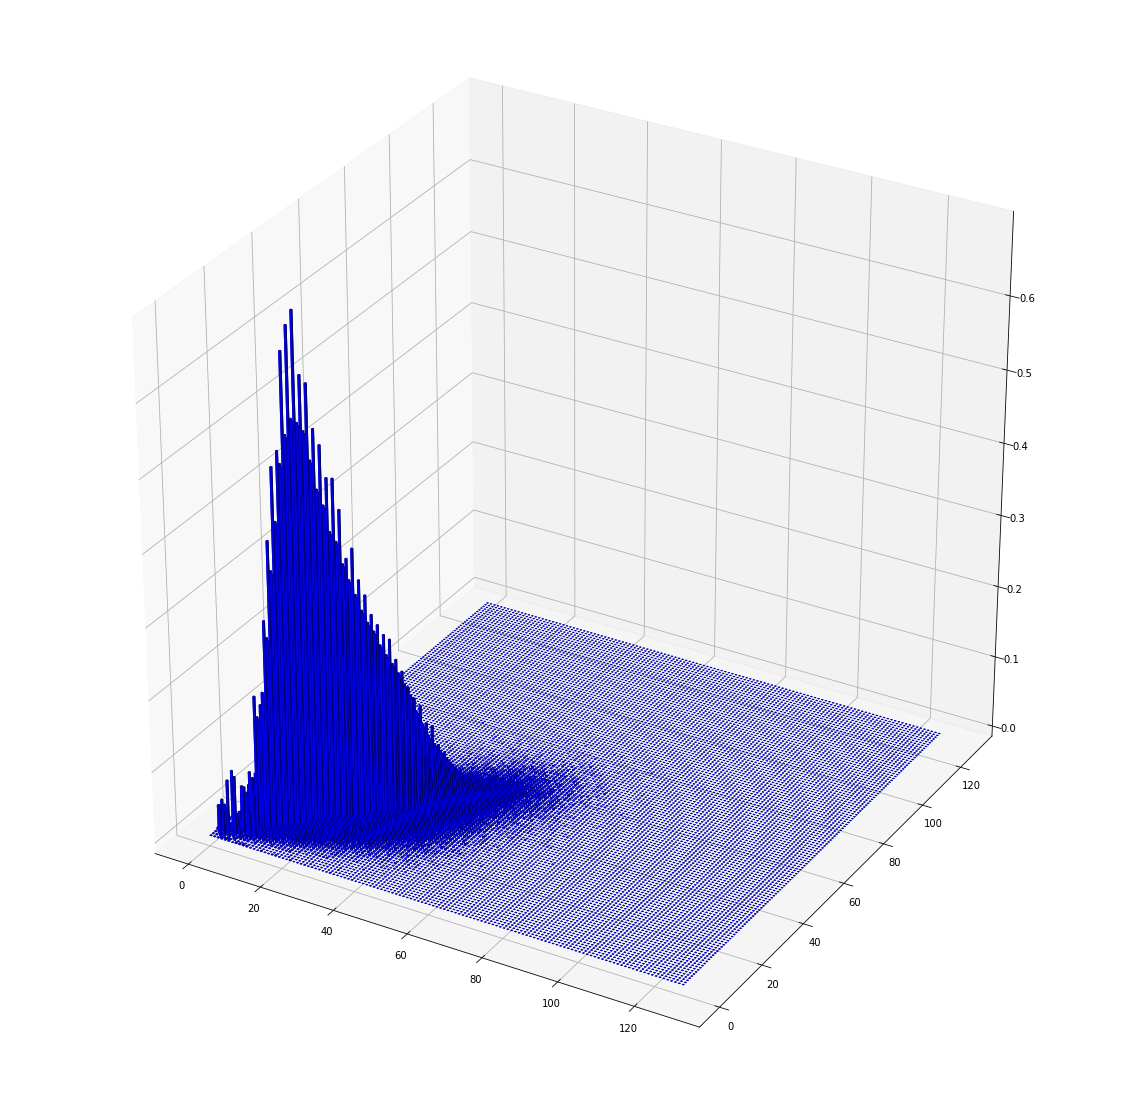

In [39]:
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=20,20
matrix = glcm_pat_sum

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xpos = [range(matrix.shape[0])]
ypos = [range(matrix.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = matrix.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
# fig=plt.figure(figsize=(20, 20), dpi= 80)
plt.savefig('Glcms_Mid_Pat.png')
plt.show()

In [ ]:
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=20,20
matrix = test_norm_sum

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xpos = [range(matrix.shape[0])]
ypos = [range(matrix.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = matrix.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
# fig=plt.figure(figsize=(20, 20), dpi= 80)
plt.savefig('Glcms_Mid_Pat.png')
plt.show()